Introduction

Everyone in today's hectic society faces pressure from a variety of sources, such as employment, education, housing, health, and so forth. Individuals in this continuously stressful setting experience a wide range of health issues. According to medical professionals, heart disease, also known as cardiovascular disease, is the main cause of mortality. Heart-related diseases account for almost 31% of deaths globally, according to data released by the World Health Organization (WHO).

The heart, one of the most vital organs in the human body, continuously and regularly pumps blood to the rest of the body to maintain normal physiological activity. Its functions include carrying oxygen, nutrients, and certain metabolites. The topic of how to track cardiac health and estimate the chance of illness has attracted a lot of attention. In order to determine the likelihood of heart disease, this article focuses on the potential predictive value of age, maximum heart rate, and resting blood pressure at admission.

In the Heart Disease dataset donated to the University of California, Irvine, a group of researchers used 14 variables to determine whether or not a patient would be diagnosed with heart disease. Using the combined data from scientists in Cleveland, Hungary, Long Island, and Switzerland as a training set for our K-nearest prediction, the given dataset will be narrowed down to answer the project-specific question. 

(Word Count: 220)

In [1]:
#Packages
#test comment
library(repr)
library(tidyverse)
library(tidymodels)
library(ggplot2)
options(repr.matrix.max.rows = 10)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [3]:
# Variables (Column names according to the dataset specification)
column_names <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", 
                  "thalach", "exang", "oldpeak", "slope", "ca", "thal", "is_disease_present")

#Datasets of Heart Disease from each country
cleveland <- read_csv("https://raw.githubusercontent.com/holiday-sean/dsci100_project/main/heart_and_disease/processed.cleveland.data", 
                                    col_names = column_names) 
hungarian <- read_csv("https://raw.githubusercontent.com/holiday-sean/dsci100_project/main/heart_and_disease/processed.hungarian.data", 
                                    col_names = column_names)
switzerland <- read_csv("https://raw.githubusercontent.com/holiday-sean/dsci100_project/main/heart_and_disease/processed.switzerland.data",
                                    col_names = column_names)
va <- read_csv("https://raw.githubusercontent.com/holiday-sean/dsci100_project/main/heart_and_disease/processed.va.data", 
                                    col_names = column_names)

#Dataset of Heart Disease (Combines the datasets from each country into one dataset)
heart_disease_cleveland <- read_csv("https://raw.githubusercontent.com/holiday-sean/dsci100_project/main/heart_and_disease/processed.cleveland.data", 
                                    col_names = column_names) |>
    mutate(is_disease_present = as.character(is_disease_present)) |>
    mutate(is_disease_present = as_factor(is_disease_present)) |>
    mutate(is_disease_present = fct_recode(is_disease_present, "No" = "0", "Yes" = "1", "Yes" = "2", "Yes" = "3", "Yes" = "4"))

heart_disease_all <- rbind(cleveland, hungarian) |>
    rbind(switzerland) |>
    rbind(va)

#Setting the 'is_disease_present' as the factor variable, and mutating it to character type instead of double type
heart_disease_all |>
    mutate(is_disease_present = as.character(is_disease_present)) |>
    mutate(is_disease_present = as_factor(is_disease_present)) |>
    mutate(is_disease_present = fct_recode(is_disease_present, "No" = "0", "Yes" = "1", "Yes" = "2", "Yes" = "3", "Yes" = "4"))

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 294 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): trestbps, chol, fbs, restecg, thalach, exang, slope, ca, thal
dbl (5): age, sex, cp, oldpeak, is_disease_present

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 123 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): trestbps, fbs, restecg, thalach, exang, oldpeak, slope, ca, thal
dbl (5): age, sex, cp, chol, is_disease_p

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,is_disease_present
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,No
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,Yes
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,Yes
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,No
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,No
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
54,0,4,127,333,1,1,154,0,0,?,?,?,Yes
62,1,1,?,139,0,1,?,?,?,?,?,?,No
55,1,4,122,223,1,1,100,0,0,?,?,6,Yes


In [4]:
heart_disease_split <- initial_split(heart_disease_cleveland, prop = 0.75, strata = is_disease_present)
cleveland_training <- training(heart_disease_split)
cleveland_testing <- testing(heart_disease_split) 

In [5]:
#Summarizing (Exploratory Analysis)

summarized_table <- cleveland_training |>
    summarize(count_disease_present = sum(is_disease_present == "Yes", na.rm = TRUE),
              count_disease_not_present = sum(is_disease_present == "No", na.rm = TRUE))

summarized_table

count_disease_present,count_disease_not_present
<int>,<int>
104,123


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


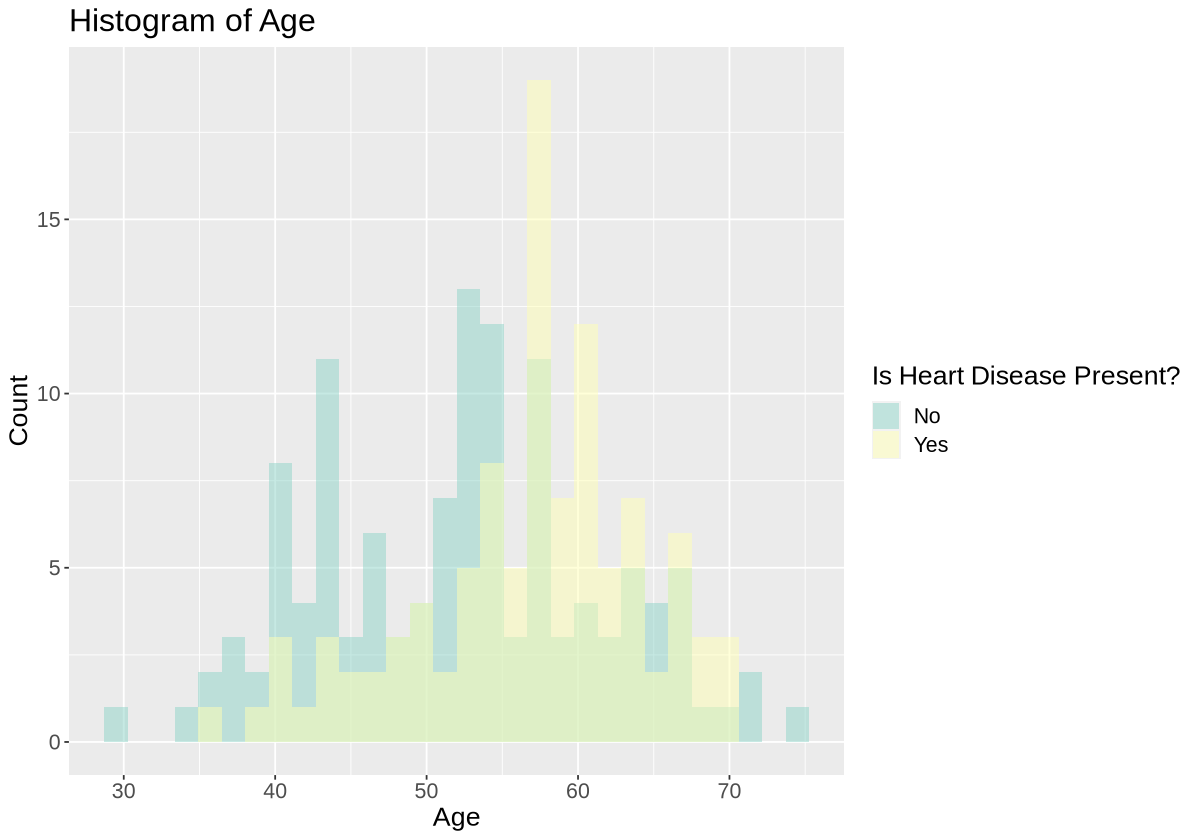

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


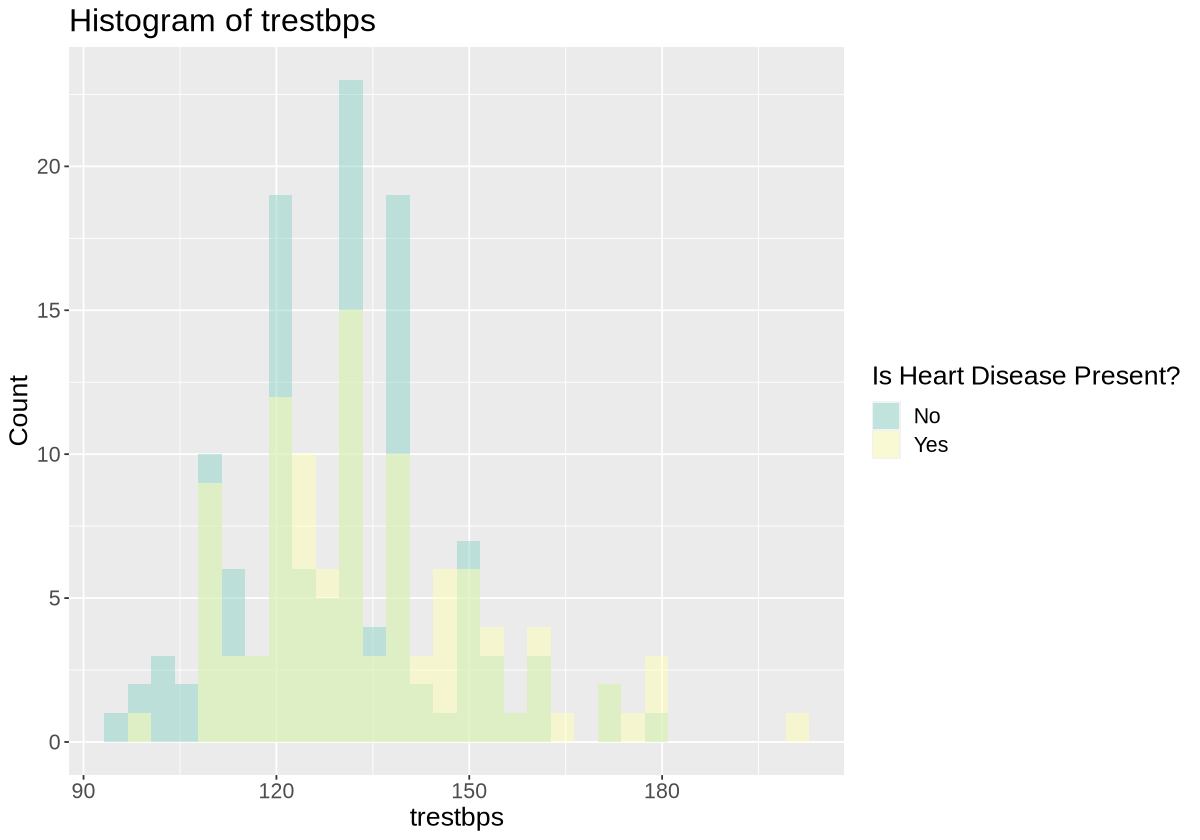

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


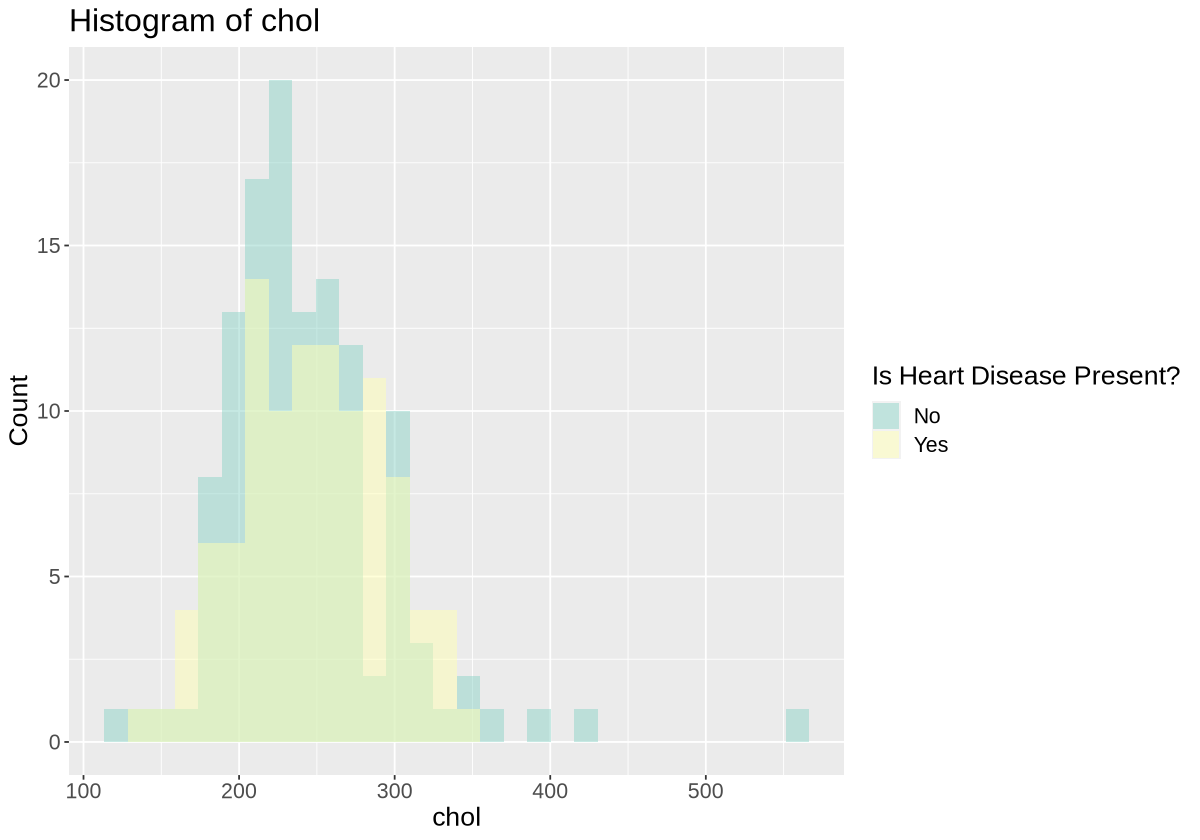

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


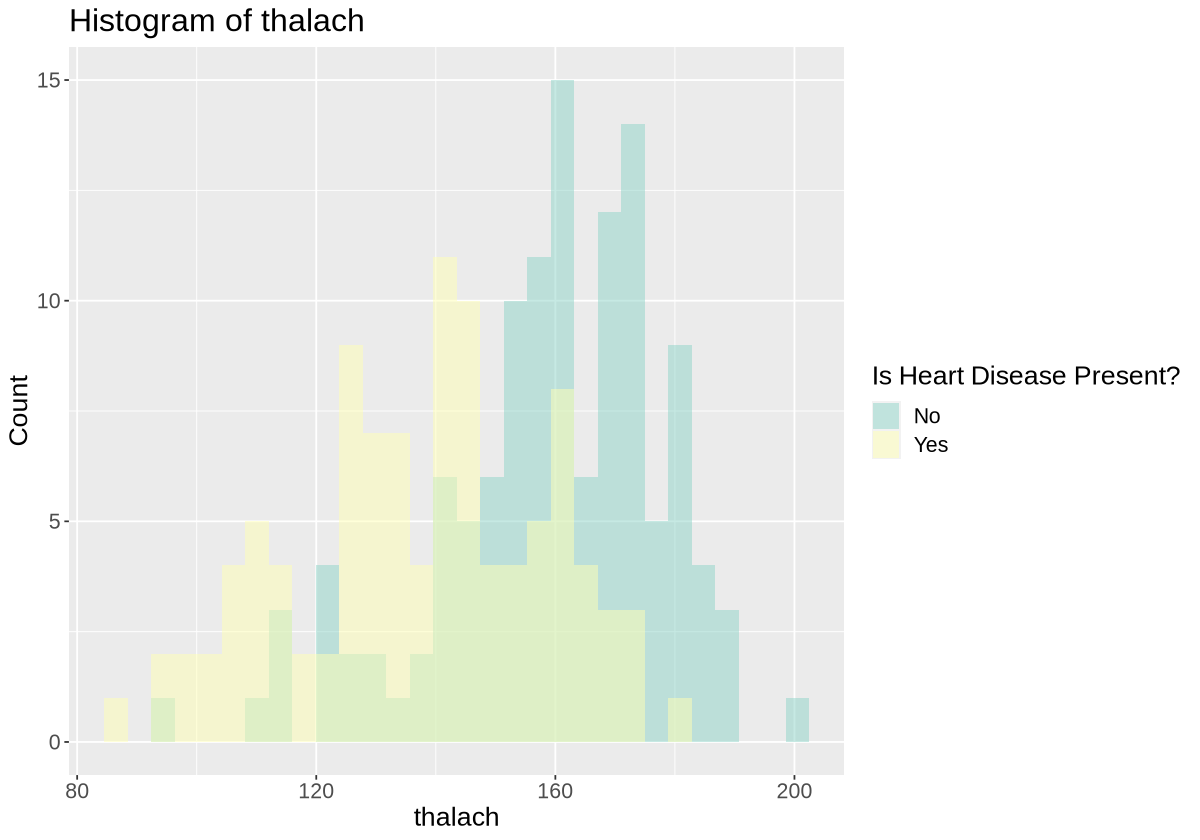

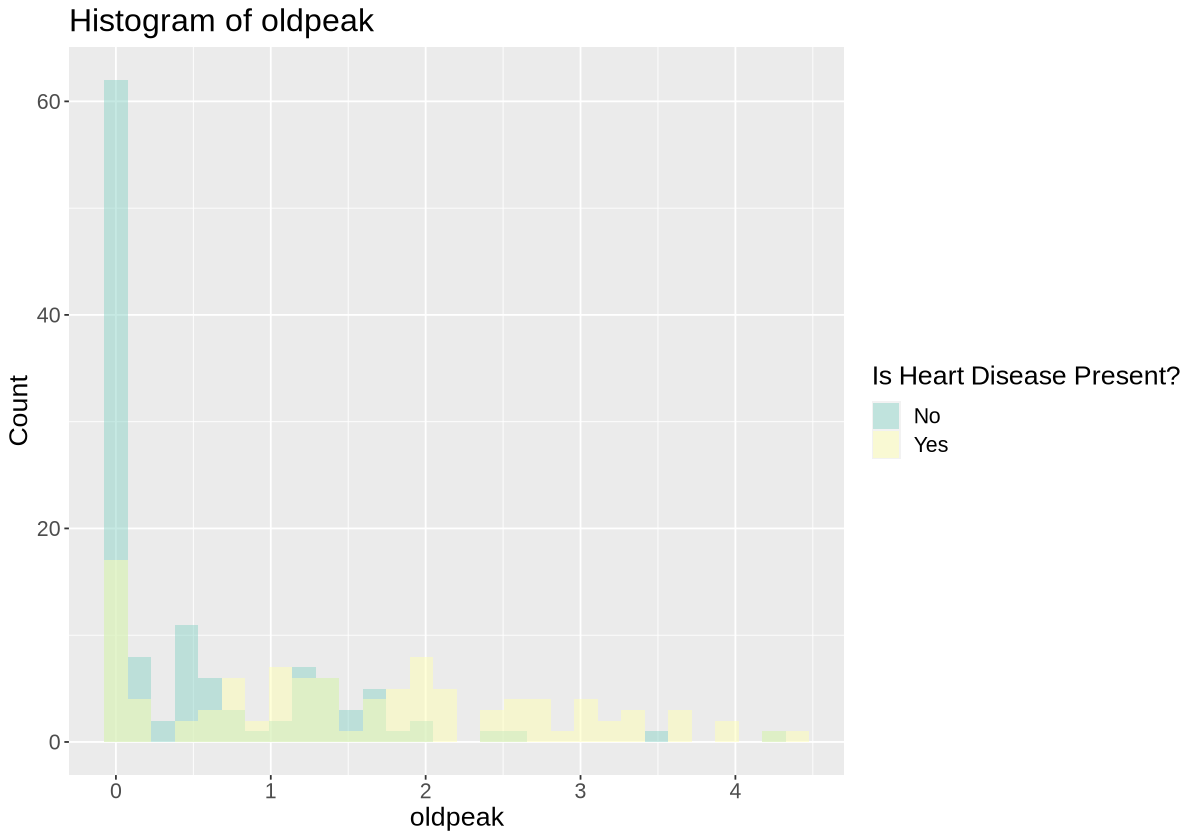

In [10]:
#Data Visualization (Exploratory Analysis)

#Quantitative Variables (age, trestbps, chol, thalach)
options(repr.plot.width = 10, repr.plot.height = 7)

quantitative_vars <- c("age", "trestbps", "chol", "thalach", "oldpeak")

age_histogram <- cleveland_training %>%
  ggplot(aes(x = age, fill = is_disease_present)) + 
  geom_histogram(alpha = 0.5,               
                 position = "identity") +  
  labs(x = "Age", y = "Count", title = "Histogram of Age", fill = "Is Heart Disease Present?") +
  scale_fill_brewer(palette = 'Set3') +
  theme(text = element_text(size = 16))

trestbps_histogram <- cleveland_training %>%
  ggplot(aes(x = trestbps, fill = is_disease_present)) + 
  geom_histogram(alpha = 0.5,               
                 position = "identity") +  
  labs(x = "trestbps", y = "Count", title = "Histogram of trestbps", fill = "Is Heart Disease Present?") +
  scale_fill_brewer(palette = 'Set3') +
  theme(text = element_text(size = 16))

chol_histogram <- cleveland_training %>%
  ggplot(aes(x = chol, fill = is_disease_present)) +  
  geom_histogram(alpha = 0.5,               
                 position = "identity") +  
  labs(x = "chol", y = "Count", title = "Histogram of chol", fill = "Is Heart Disease Present?") +
  scale_fill_brewer(palette = 'Set3') +
  theme(text = element_text(size = 16))  

thalach_histogram <- cleveland_training %>%
  ggplot(aes(x = thalach, fill = is_disease_present)) +  
  geom_histogram(alpha = 0.5,               
                 position = "identity") +  
  labs(x = "thalach", y = "Count", title = "Histogram of thalach", fill = "Is Heart Disease Present?") +
  scale_fill_brewer(palette = 'Set3') +
  theme(text = element_text(size = 16))

oldpeak_histogram <- cleveland_training %>%
  ggplot(aes(x = oldpeak, fill = is_disease_present)) +  
  geom_histogram(alpha = 0.5,               
                 position = "identity") +  
  labs(x = "oldpeak", y = "Count", title = "Histogram of oldpeak", fill = "Is Heart Disease Present?") +
  scale_fill_brewer(palette = 'Set3') +
  theme(text = element_text(size = 16))   

age_histogram
trestbps_histogram
chol_histogram
thalach_histogram
oldpeak_histogram

`summarise()` has grouped output by 'is_disease_present'. You can override
using the `.groups` argument.
`summarise()` has grouped output by 'is_disease_present'. You can override
using the `.groups` argument.


is_disease_present,cp,count
<fct>,<fct>,<int>
No,Typical Angina,9
No,Atypical Angina,28
No,Non-Anginal Pain,57
No,Asymptomatic,29
Yes,Typical Angina,4
Yes,Atypical Angina,6
Yes,Non-Anginal Pain,14
Yes,Asymptomatic,80


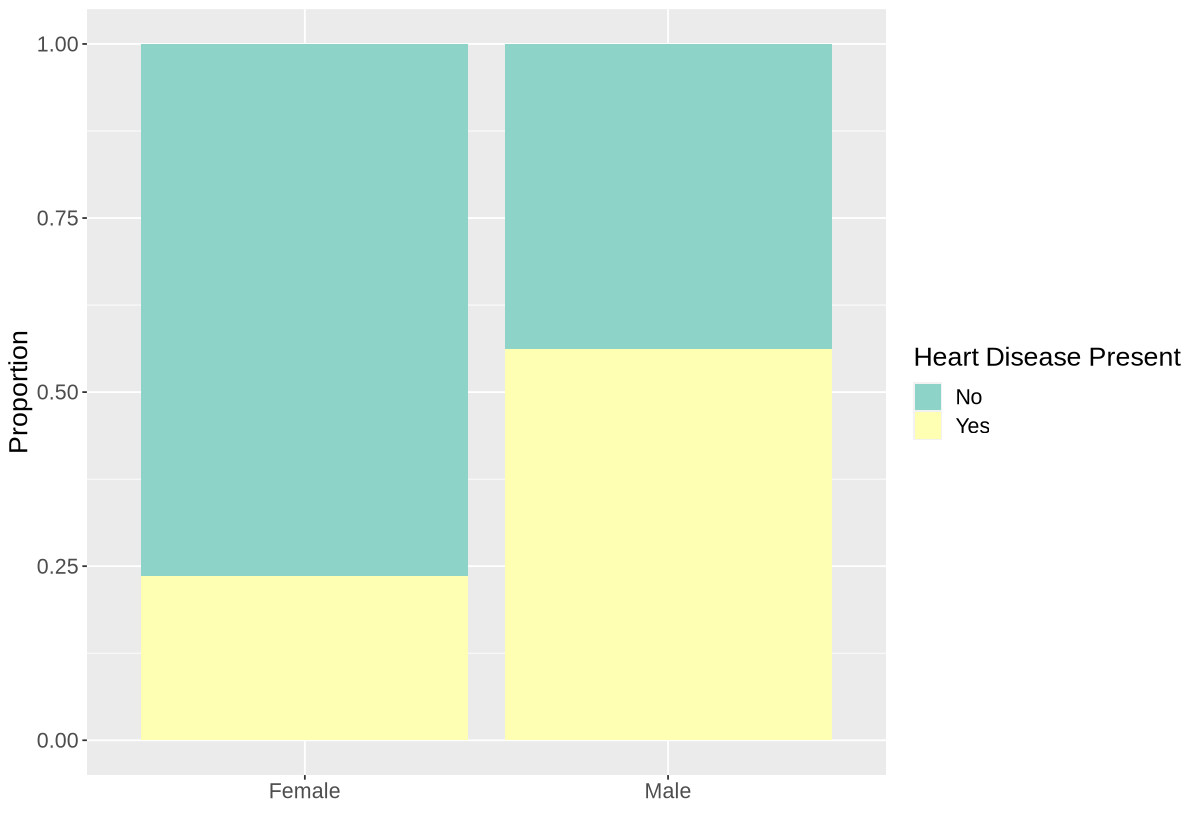

`summarise()` has grouped output by 'is_disease_present'. You can override
using the `.groups` argument.


is_disease_present,count,exercise_induced_angina
<fct>,<int>,<fct>
No,107,No
No,16,Yes
Yes,42,No
Yes,62,Yes


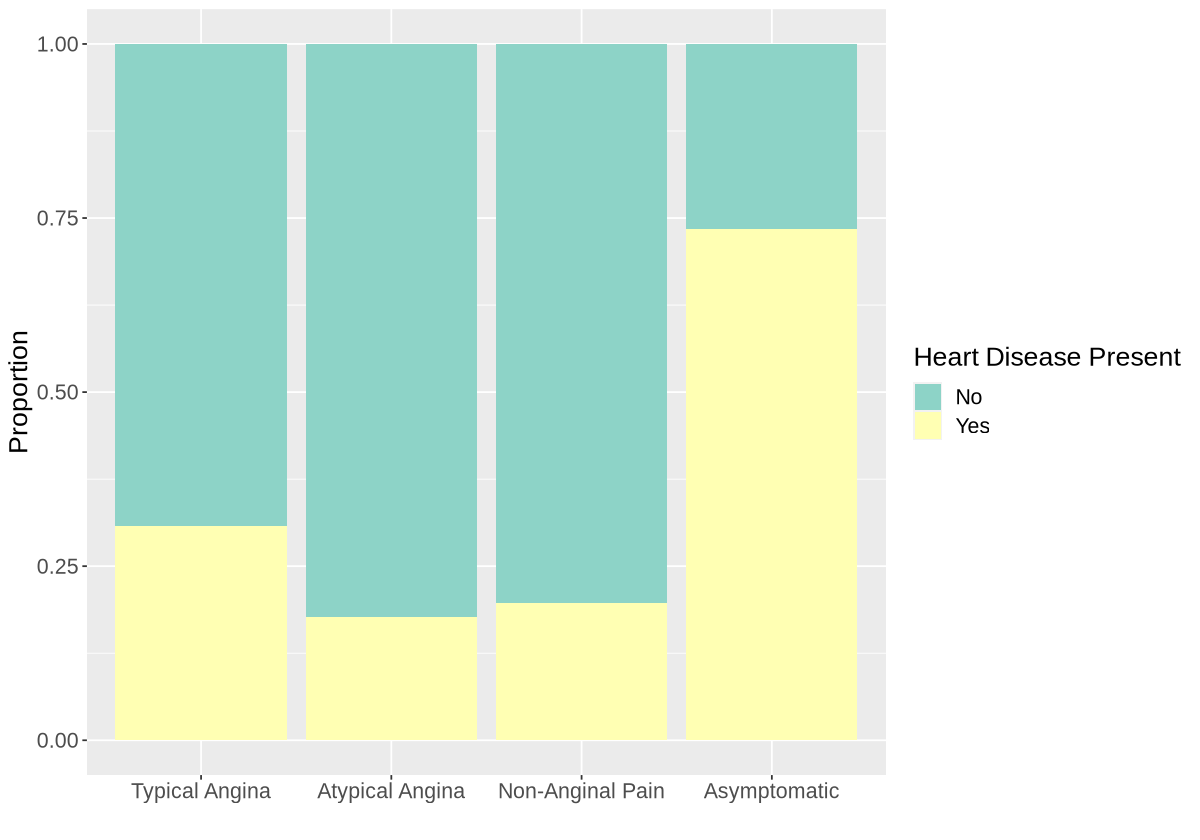

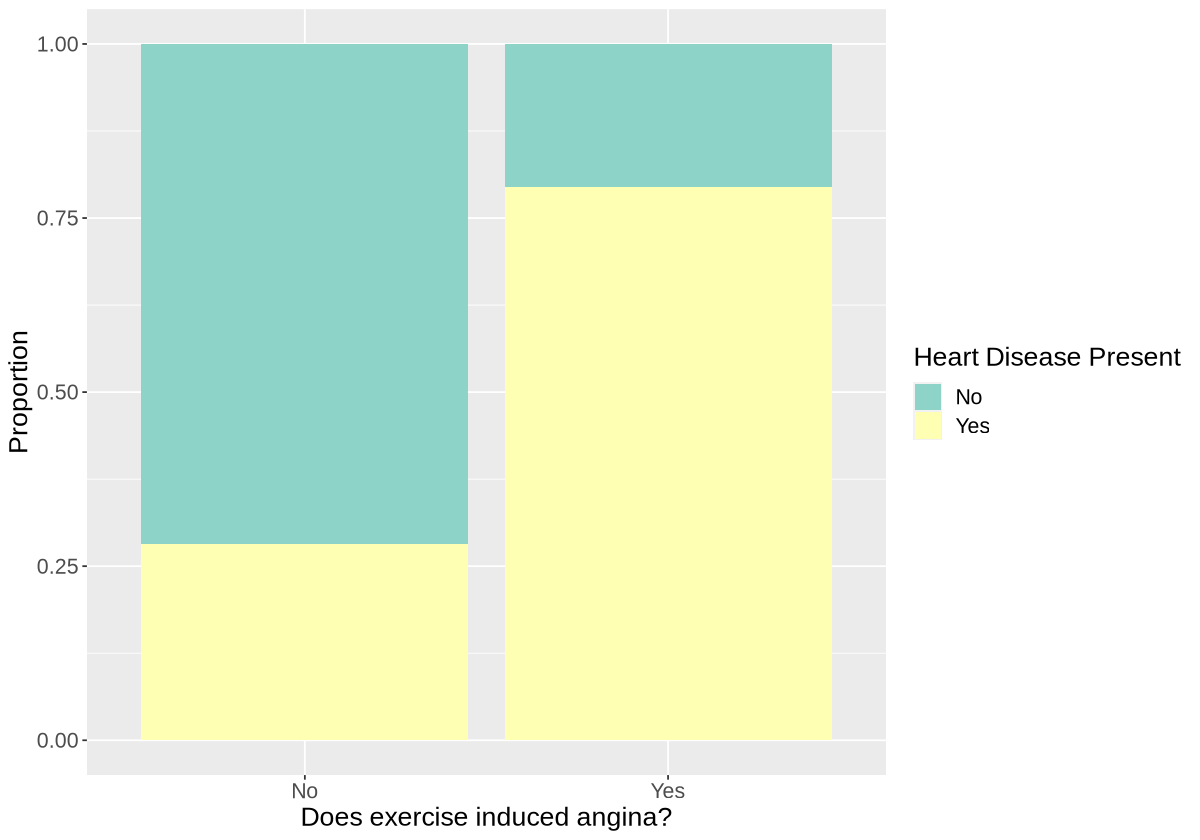

In [12]:
#Data Visualization (Exploratory Analysis - We probably will not use this...)

#Qualitative Variables (sex, cp, fbs, restecg, exang, xhypo, slope, ca, thal)
options(repr.plot.width = 10, repr.plot.height = 7)

sex_data <- cleveland_training |>
    group_by(is_disease_present, sex) |>
    summarize(count = n()) |>
    mutate(sex = as.character(sex)) |>
    mutate(sex = fct_recode(sex, "Male" = "1", "Female" = "0"))

sex_plot <- sex_data |>
    ggplot(aes(x = sex,y = count, fill = is_disease_present)) + 
    geom_bar(stat = "identity", position = "fill") + 
    labs(fill = "Heart Disease Present", x = "", y = "Proportion") +
    scale_fill_brewer(palette = 'Set3') +
    theme(text = element_text(size = 16))

sex_plot

cp_data <- cleveland_training |>
    group_by(is_disease_present, cp) |>
    summarize(count = n()) |>
    mutate(cp = as.character(cp)) |>
    mutate(cp = fct_recode(cp, "Typical Angina" = "1", 
                                "Atypical Angina" = "2",
                                "Non-Anginal Pain" = "3",
                                "Asymptomatic" = "4"))

cp_data

cp_plot <- cp_data |>
    ggplot(aes(x = cp, y = count, fill = is_disease_present)) + 
    geom_bar(stat = "identity", position = "fill") + 
    labs(fill = "Heart Disease Present", x = "", y = "Proportion") +
    scale_fill_brewer(palette = 'Set3') +
    theme(text = element_text(size = 16))

cp_plot

exang_data <- cleveland_training |>
    group_by(is_disease_present, exang) |>
    summarize(count = n()) |>
    mutate(exang = as.character(exang)) |>
    mutate(exang = fct_recode(exang, "No" = "0", "Yes" = "1")) |>
    mutate(exercise_induced_angina = exang) |>
    select(-exang) 
    
exang_data

exang_plot <- exang_data |>
    ggplot(aes(x = exercise_induced_angina, y = count, fill = is_disease_present)) + 
    geom_bar(stat = "identity", position = "fill") +
    labs(fill = "Heart Disease Present", x = "Does exercise induced angina?", y = "Proportion") +
    scale_fill_brewer(palette = 'Set3') +
    theme(text = element_text(size = 16))

exang_plot

**Expected Outcomes and Significance**

**Expected finding**: With the increasing age, maximum heart rate, and resting blood pressure at admission, the likelihood of having heart disease is going to increase too.

**The impact of the finding**: Helping people to predict heart diseases better, or avoid getting heart diseases by gaining a better understanding of the associated risk factors.

**The future question**: We only examined the relationship between heart disease between 3 variables, but there are a total of 14 variables in the original dataset. There are more variables to be studied based on their relationships with heart disease.
